# EECS 442 Assignment 5(1): Fashion-MNIST Classification
In this part, you will implement and train Convolutional Neural Networks (ConvNets) in PyTorch to classify images. Unlike HW4, backpropagation is automatically inferred by PyTorch, so you only need to write code for the forward pass.

Before we start, please put your name and UMID in following format

: Firstname LASTNAME, #00000000   //   e.g.) Justin JOHNSON, #12345678

**Your Answer:**   
Hello WORLD, #XXXXXXXX

## Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # Displays a progress bar

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchsummary import summary
from torchvision import datasets, transforms
from torch.utils.data import Dataset, Subset, DataLoader, random_split

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

## Loading Dataset
The dataset we use is Fashion-MNIST dataset, which is available at https://github.com/zalandoresearch/fashion-mnist and in torchvision.datasets. Fashion-MNIST has 10 classes, 60000 training+validation images (we have splitted it to have 50000 training images and 10000 validation images, but you can change the numbers), and 10000 test images.

In [4]:
# Load the dataset and train, val, test splits
print("Loading datasets...")
# Transform from [0,255] uint8 to [0,1] float,
# then normalize to zero mean and unit variance
FASHION_transform = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize([0.2859], [0.3530]) 
                    ])
FASHION_trainval = datasets.FashionMNIST('.', download=True, train=True,
                                         transform=FASHION_transform)
FASHION_train = Subset(FASHION_trainval, range(50000))
FASHION_val = Subset(FASHION_trainval, range(50000, 60000))
FASHION_test = datasets.FashionMNIST('.', download=True, train=False,
                                     transform=FASHION_transform)
print("Done!")

Loading datasets...


26422272it [00:01, 17002027.57it/s]                              


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



29696it [00:00, 235158.06it/s]                           


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



4422656it [00:01, 4310232.24it/s]                             


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



6144it [00:00, 13620403.69it/s]         

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw

Done!


Now, we will create the dataloder for train, val and test dataset. You are free to experiment with different batch sizes.

In [5]:
# Create dataloaders
##############################################################################
# TODO: Experiment with different batch sizes                                #
##############################################################################
trainloader = DataLoader(FASHION_train, batch_size=64, shuffle=True)
valloader = DataLoader(FASHION_val, batch_size=64, shuffle=True)
testloader = DataLoader(FASHION_test, batch_size=64, shuffle=True)
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

## Model
Initialize your model and experiment with with different optimizers, parameters (such as learning rate) and number of epochs.

In [30]:
class Network(nn.Module):
  def __init__(self):
    super().__init__()
    ##############################################################################
    # TODO: Design your own network, define layers here.                          #
    # Here We provide a sample of two-layer fc network from HW4 Part3.           #
    # Your solution, however, should contain convolutional layers.               #
    # Refer to PyTorch documentations of torch.nn to pick your layers.           #
    # (https://pytorch.org/docs/stable/nn.html)                                  #
    # Some common choices: Linear, Conv2d, ReLU, MaxPool2d, AvgPool2d, Dropout   #
    # If you have many layers, use nn.Sequential() to simplify your code         #
    ##############################################################################
    # from 28x28 input image to hidden layer of size 256
    
    # self.fc1 = nn.Linear(28*28, 8) 
    # # from hidden layer to 10 class scores
    # self.fc2 = nn.Linear(8,10)

    self.features=nn.Sequential(
      nn.Conv2d(1,12,(5,5),),
      nn.ReLU(),
      nn.MaxPool2d((2,2),2),
      nn.Conv2d(12,24,(5,5)),
      nn.ReLU(),
      nn.MaxPool2d((2,2),2),
      nn.Flatten(),
      nn.Linear(384,10)
    )
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
  
  def forward(self,x):
    ##############################################################################
    # TODO: Design your own network, implement forward pass here                 # 
    ##############################################################################
    # Flatten each image in the batch
    x = self.features(x)
    return x
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################

model = Network().to(device)
criterion = nn.CrossEntropyLoss() # Specify the loss layer
print('Your network:')
print(summary(model, (1,28,28))) # visualize your model

##############################################################################
# TODO: Modify the lines below to experiment with different optimizers,      #
# parameters (such as learning rate) and number of epochs.                   #
##############################################################################
# Set up optimization hyperparameters
learning_rate = 1e-2
weight_decay = 1e-4
num_epoch = 10  # TODO: Choose an appropriate number of training epochs
optimizer = optim.Adam(model.parameters(), lr=learning_rate,
                       weight_decay=weight_decay)
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

Your network:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 24, 24]             312
              ReLU-2           [-1, 12, 24, 24]               0
         MaxPool2d-3           [-1, 12, 12, 12]               0
            Conv2d-4             [-1, 24, 8, 8]           7,224
              ReLU-5             [-1, 24, 8, 8]               0
         MaxPool2d-6             [-1, 24, 4, 4]               0
           Flatten-7                  [-1, 384]               0
            Linear-8                   [-1, 10]           3,850
Total params: 11,386
Trainable params: 11,386
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.15
Params size (MB): 0.04
Estimated Total Size (MB): 0.19
----------------------------------------------------------------
None


Run the cell below to start your training, we expect you to achieve over **85%** on the test set.

In [31]:
%%time
def train(model, trainloader, valloader, num_epoch = 10): # Train the model
  print("Start training...")
  trn_loss_hist = []
  trn_acc_hist = []
  val_acc_hist = []
  model.train() # Set the model to training mode
  for i in range(num_epoch):
    running_loss = []
    print('-----------------Epoch = %d-----------------' % (i+1))
    for batch, label in tqdm(trainloader):
      batch = batch.to(device)
      label = label.to(device)
      optimizer.zero_grad() # Clear gradients from the previous iteration
      pred = model(batch) # This will call Network.forward() that you implement
      loss = criterion(pred, label) # Calculate the loss
      running_loss.append(loss.item())
      loss.backward() # Backprop gradients to all tensors in the network
      optimizer.step() # Update trainable weights
    print("\n Epoch {} loss:{}".format(i+1,np.mean(running_loss)))

    # Keep track of training loss, accuracy, and validation loss
    trn_loss_hist.append(np.mean(running_loss))
    trn_acc_hist.append(evaluate(model, trainloader))
    print("\n Evaluate on validation set...")
    val_acc_hist.append(evaluate(model, valloader))
  print("Done!")
  return trn_loss_hist, trn_acc_hist, val_acc_hist

def evaluate(model, loader): # Evaluate accuracy on validation / test set
  model.eval() # Set the model to evaluation mode
  correct = 0
  with torch.no_grad(): # Do not calculate grident to speed up computation
    for batch, label in tqdm(loader):
      batch = batch.to(device)
      label = label.to(device)
      pred = model(batch)
      correct += (torch.argmax(pred,dim=1)==label).sum().item()
    acc = correct/len(loader.dataset)
    print("\n Evaluation accuracy: {}".format(acc))
    return acc
    
trn_loss_hist, trn_acc_hist, val_acc_hist = train(model, trainloader, 
                                                  valloader, num_epoch)

##############################################################################
# TODO: Note down the evaluation accuracy on test set                        #
##############################################################################
print("\n Evaluate on test set")
evaluate(model, testloader)

Start training...
-----------------Epoch = 1-----------------


100%|██████████| 782/782 [00:16<00:00, 48.07it/s]



 Epoch 1 loss:0.5032361295274304


100%|██████████| 782/782 [00:08<00:00, 93.69it/s]



 Evaluation accuracy: 0.8581

 Evaluate on validation set...


100%|██████████| 157/157 [00:01<00:00, 92.39it/s]



 Evaluation accuracy: 0.8479
-----------------Epoch = 2-----------------


100%|██████████| 782/782 [00:15<00:00, 49.00it/s]



 Epoch 2 loss:0.3927070031042599


100%|██████████| 782/782 [00:08<00:00, 94.64it/s]



 Evaluation accuracy: 0.86684

 Evaluate on validation set...


100%|██████████| 157/157 [00:01<00:00, 95.71it/s]



 Evaluation accuracy: 0.8582
-----------------Epoch = 3-----------------


100%|██████████| 782/782 [00:15<00:00, 50.08it/s]



 Epoch 3 loss:0.3728932401122492


100%|██████████| 782/782 [00:08<00:00, 95.35it/s]



 Evaluation accuracy: 0.87696

 Evaluate on validation set...


100%|██████████| 157/157 [00:01<00:00, 95.85it/s]



 Evaluation accuracy: 0.8666
-----------------Epoch = 4-----------------


100%|██████████| 782/782 [00:15<00:00, 48.95it/s]



 Epoch 4 loss:0.3629093559177788


100%|██████████| 782/782 [00:08<00:00, 92.75it/s]



 Evaluation accuracy: 0.8768

 Evaluate on validation set...


100%|██████████| 157/157 [00:01<00:00, 93.77it/s]



 Evaluation accuracy: 0.8638
-----------------Epoch = 5-----------------


100%|██████████| 782/782 [00:16<00:00, 48.58it/s]



 Epoch 5 loss:0.35599998535250155


100%|██████████| 782/782 [00:08<00:00, 90.39it/s]



 Evaluation accuracy: 0.88148

 Evaluate on validation set...


100%|██████████| 157/157 [00:01<00:00, 93.12it/s]



 Evaluation accuracy: 0.8664
-----------------Epoch = 6-----------------


100%|██████████| 782/782 [00:16<00:00, 48.42it/s]



 Epoch 6 loss:0.35400919927774793


100%|██████████| 782/782 [00:08<00:00, 92.42it/s]



 Evaluation accuracy: 0.88048

 Evaluate on validation set...


100%|██████████| 157/157 [00:01<00:00, 90.29it/s]



 Evaluation accuracy: 0.8628
-----------------Epoch = 7-----------------


100%|██████████| 782/782 [00:15<00:00, 49.19it/s]



 Epoch 7 loss:0.34487258285627037


100%|██████████| 782/782 [00:08<00:00, 90.19it/s]



 Evaluation accuracy: 0.88128

 Evaluate on validation set...


100%|██████████| 157/157 [00:01<00:00, 93.12it/s]



 Evaluation accuracy: 0.8645
-----------------Epoch = 8-----------------


100%|██████████| 782/782 [00:16<00:00, 48.67it/s]



 Epoch 8 loss:0.34906639677979756


100%|██████████| 782/782 [00:08<00:00, 92.72it/s]



 Evaluation accuracy: 0.86864

 Evaluate on validation set...


100%|██████████| 157/157 [00:01<00:00, 93.19it/s]



 Evaluation accuracy: 0.8574
-----------------Epoch = 9-----------------


100%|██████████| 782/782 [00:16<00:00, 48.61it/s]



 Epoch 9 loss:0.3475671285272712


100%|██████████| 782/782 [00:08<00:00, 89.65it/s]



 Evaluation accuracy: 0.87734

 Evaluate on validation set...


100%|██████████| 157/157 [00:01<00:00, 87.00it/s]



 Evaluation accuracy: 0.8588
-----------------Epoch = 10-----------------


100%|██████████| 782/782 [00:16<00:00, 47.97it/s]



 Epoch 10 loss:0.3364583899450424


100%|██████████| 782/782 [00:08<00:00, 88.36it/s]



 Evaluation accuracy: 0.89014

 Evaluate on validation set...


100%|██████████| 157/157 [00:01<00:00, 87.97it/s]



 Evaluation accuracy: 0.871
Done!

 Evaluate on test set


100%|██████████| 157/157 [00:01<00:00, 86.53it/s]


 Evaluation accuracy: 0.8712
CPU times: user 4min 52s, sys: 4.62 s, total: 4min 56s
Wall time: 4min 24s


0.8712

Once your training is complete, run the cell below to visualize the training and validation accuracies across iterations.

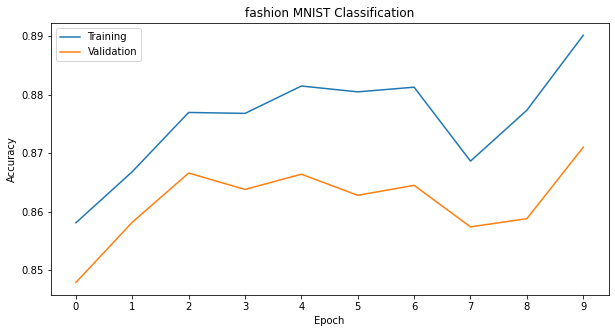

In [33]:
##############################################################################
# TODO: Submit the accuracy plot                                             #
##############################################################################
# visualize the training / validation accuracies
x = np.arange(num_epoch)
# train/val accuracies for MiniVGG
plt.figure()
plt.plot(x, trn_acc_hist)
plt.plot(x, val_acc_hist)
plt.legend(['Training', 'Validation'])
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('fashion MNIST Classification')
plt.gcf().set_size_inches(10, 5)
plt.show()